In [5]:
# install.packages('comprehenr')
# install.packages("raster", dependencies=TRUE)
# install.packages('stringr')
# install.packages('ncdf4')
# install.packages('dplyr')

In [1]:
library(raster)
library(ncdf4)
library(rgdal)
library(comprehenr)
library(glue)
library(stringr)
library(mopa)
library(dplyr)

Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-25, (SVN revision 1143)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.4.0, released 2018/12/14
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
Path to PROJ shared files: (autodetected)
Linking to sp version:1.4-5


Attaching package: ‘glue’


The following object is masked from ‘package:raster’:

    trim



Attaching package: ‘dplyr’


The following object is masked from ‘package:glue’:

    collapse


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, 

In [2]:
cropCountry <- function(baseRaster, country)
{
    if (typeof(country) == 'list'){
        countrySPDF <- getData("GADM",country=country[[1]],level=0) 
        for (country_ in tail(country, -1)){
            countrySPDF <- raster::bind(countrySPDF, getData("GADM",country=country_[[1]],level=0))
        }
    } else if (typeof(country) == 'character'){
        countrySPDF <- getData("GADM",country=country,level=0)
    }
    croppedRaster <- mask(crop(baseRaster, extent(countrySPDF)), countrySPDF)
    return(croppedRaster)
}

get_country_extent <- function(country)
{
    if (typeof(country) == 'list'){
        countrySPDF <- getData("GADM",country=country[[1]],level=0) 
        for (country_ in tail(country, -1)){
            countrySPDF <- raster::bind(countrySPDF, getData("GADM",country=country_[[1]],level=0))
        }
    } else if (typeof(country) == 'character'){
        countrySPDF <- getData("GADM",country=country,level=0)
    }
    return(extent(countrySPDF))
}

aggregateSM_NASA <- function(year, month, basePath){
    base_name <- glue("{basePath}/GLDAS_NOAH025_3H.A{year}{str_pad(month, width=2, pad='0')}")
    decade1 <- unlist(to_list(for (day in 1:10) Sys.glob(glue("{base_name}{sprintf('%02d', day)}*.nc4"))))
    decade2 <- unlist(to_list(for (day in 11:20) Sys.glob(glue("{base_name}{sprintf('%02d', day)}*.nc4"))))
    decade3 <- unlist(to_list(for (day in 21:31) Sys.glob(glue("{base_name}{sprintf('%02d', day)}*.nc4"))))

    decade1 <- stack(calc(stack(decade1, varname="SoilMoi0_10cm_inst"), mean), calc(stack(decade1, varname="SoilMoi10_40cm_inst"), mean))
    decade2 <- stack(calc(stack(decade2, varname="SoilMoi0_10cm_inst"), mean), calc(stack(decade2, varname="SoilMoi10_40cm_inst"), mean))
    decade3 <- stack(calc(stack(decade3, varname="SoilMoi0_10cm_inst"), mean), calc(stack(decade3, varname="SoilMoi10_40cm_inst"), mean))

    sm <- stack(decade1, decade2, decade3)
    names(sm) <- c('dekad1_0_10', 'dekad1_10_40', 'dekad2_0_10', 'dekad2_10_40', 'dekad3_0_10', 'dekad3_10_40')
    return(sm)
}
                              
aggregateSM_SMELLS <- function(year, month, basePath){
    base_name <- glue("{basePath}/{year}{str_pad(month, width=2, pad='0')}")
    tif_files <- Sys.glob(glue("{base_name}/*"))
    
    sm_stack <- stack(tif_files)
    sm_stack <- sm_stack/100
    sm_stack[is.na(sm_stack)] <- 0
    names(sm_stack) <- c('dekad1', 'dekad2', 'dekad3')
    return(sm_stack)
}
                              
subsetCountry <- function(country, data){
    if (typeof(country) == 'list'){
        countrySPDF <- getData("GADM",country=country[[1]],level=0) 
        for (country_ in tail(country, -1)){
            countrySPDF <- raster::bind(countrySPDF, getData("GADM",country=country_[[1]],level=0))
        }
    } else if (typeof(country) == 'character'){
        countrySPDF <- getData("GADM",country=country,level=0)
    }
    locs <- data.frame(x=data$X, y=data$Y)
    coordinates(locs) <- c("x","y")
    projection(locs) <- CRS("+proj=longlat +init=epsg:4326")
    projection(countrySPDF) <- CRS("+proj=longlat +init=epsg:4326")
    countryID <- over(locs, countrySPDF)
    data_subset <- data
    data_subset['COUNTRY'] <- countryID$NAME_0
    
    if (typeof(country) == 'list'){
        data_subset <- data_subset[data_subset$COUNTRY %in% country,]
    } else if (typeof(country) == 'character'){
        data_subset <- data_subset[data_subset$COUNTRY == country,]
    }
    
    return(data_subset)
}


finalize_data <- function(pa_generation, data, no_generation){
    if (no_generation){
        final_data <- data.frame(x=pa_generation$x, y=pa_generation$y, presence=pa_generation$v)
    } else {
        final_data <- data.frame(x=pa_generation$species1$PA01[[1]]$x, y=pa_generation$species1$PA01[[1]]$y, presence=pa_generation$species1$PA01[[1]]$v)
    }
    final_data['year'] = data$year
    final_data['month'] = data$month
    final_data['day'] = 0
    final_data['country'] = data$COUNTRY
    final_data[final_data$presence == 1, 'day'] <- data$day

    if (! no_generation){
        random_days <- sampleInt(28, length(final_data[final_data$presence != 1, 'day']), replace=TRUE)
        final_data[final_data$presence != 1, 'day'] <- random_days

    }
    return(final_data)
}


extract_values <- function(locs, raster_data){
    sp <- SpatialPoints(locs)
    data <- extract(raster_data, sp, method='bilinear')
    return(data)
}

In [3]:
get_soil_profile <- function(basePath, raster_extent, country) {
    clay0_5 <- cropCountry(raster(glue('{basePath}/clay_0-5cm_mean.tif')), country)
    extent(clay0_5) <- raster_extent

    clay5_15 <- cropCountry(raster(glue('{basePath}/clay_5-15cm_mean.tif')), country)
    extent(clay5_15) <- raster_extent

    sand0_5 <- cropCountry(raster(glue('{basePath}/sand_0-5cm_mean.tif')), country)
    extent(sand0_5) <- raster_extent

    sand5_15 <- cropCountry(raster(glue('{basePath}/sand_5-15cm_mean.tif')), country)
    extent(sand5_15) <- raster_extent

    silt0_5 <- cropCountry(raster(glue('{basePath}/silt_0-5cm_mean.tif')), country)
    extent(silt0_5) <- raster_extent

    silt5_15 <- cropCountry(raster(glue('{basePath}/silt_5-15cm_mean.tif')), country)
    extent(silt5_15) <- raster_extent

    soil_profile <- stack(c(clay0_5, clay5_15, sand0_5, sand5_15, silt0_5, silt5_15))
    soil_profile <- soil_profile/1000
    soil_profile[is.na(soil_profile)] <- 0
    return(soil_profile)
}

In [4]:
swarms_fao_data <- read.csv(file = 'Hoppers.csv')
head(swarms_fao_data)

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,⋯,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT
,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,37.333333,19.31667,1,1985/12/30 00:00:00+00,12:00,1985/12/30 00:00:00+00,12:00,No,Late,Khor Hambokeib,⋯,,0,,0,0,0,0,0,0,Hopper
2,37.350000,19.23333,2,1985/12/30 00:00:00+00,12:00,1985/12/30 00:00:00+00,12:00,No,Late,Khor Handub,⋯,,0,,0,0,0,0,0,0,Hopper
3,-14.917778,16.95167,3,1985/10/18 00:00:00+00,12:00,1985/10/18 00:00:00+00,12:00,No,Middle,,⋯,,0,,0,0,0,0,0,0,Hopper
4,-0.381650,18.66083,4,1985/10/15 00:00:00+00,12:00,1985/10/15 00:00:00+00,12:00,Yes,,,⋯,,0,,0,0,0,0,0,0,Hopper
5,1.522778,20.93833,5,1985/11/06 00:00:00+00,12:00,1985/11/06 00:00:00+00,12:00,No,Early,,⋯,,0,,0,0,0,0,0,0,Hopper
6,4.216111,18.63500,6,1985/11/15 00:00:00+00,12:00,1985/11/15 00:00:00+00,12:00,Yes,,,⋯,,0,,0,0,0,0,0,0,Hopper


In [5]:
country <- list('Mauritania', 'Mali')
soil_profile <- get_soil_profile('full_isric_data', get_country_extent(country), country)
country_data <- subsetCountry(country, swarms_fao_data)
date <- as.POSIXct(country_data[['STARTDATE']], format = "%Y/%m/%d %H:%M:%S")
country_data[['yearmonth']] <- format(date, format="%Y%m")
country_data[['year']] <- format(date, format="%Y")
country_data[['month']] <- format(date, format="%m")
country_data[['day']] <- format(date, format="%d")

In [6]:
unique(country_data$COUNTRY)

[1] "Mauritania" "Mali"

In [7]:
unique(country_data$year)

[1] "1985" "1986" "1987" "1988" "1989" "1990" "1991" "1992" "1993" "1994"
[11] "1995" "1996" "1997" "1998" "1999" "2000" "2001" "2002" "2003" "2004"
[21] "2005" "2006" "2007" "2008" "2009" "2010" "2011" "2012" "2013" "2014"
[31] "2015" "2016" "2017" "2018" "2019" "2020" "2021"

In [8]:
fao_yearmonths <- as.numeric(unique(country_data$yearmonth))
nasa_yearmonths <- fao_yearmonths[fao_yearmonths >= 200000 & fao_yearmonths <= 201100]
smells_yearmonths <- fao_yearmonths[fao_yearmonths >= 201000 & fao_yearmonths <= 201807]

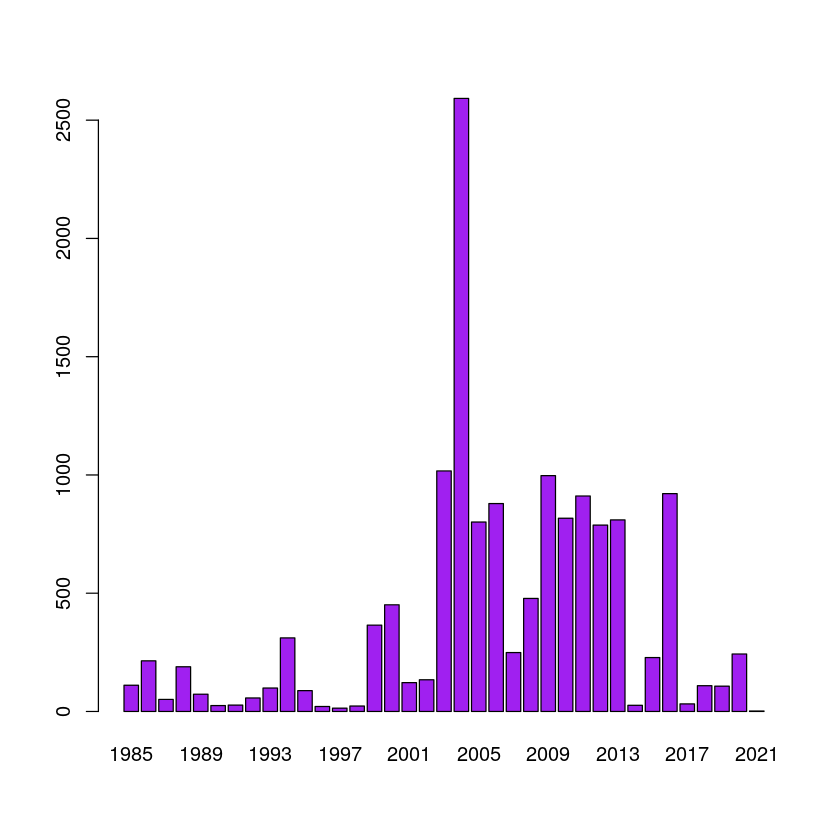

In [9]:
barplot(table(country_data$year), col= "purple")

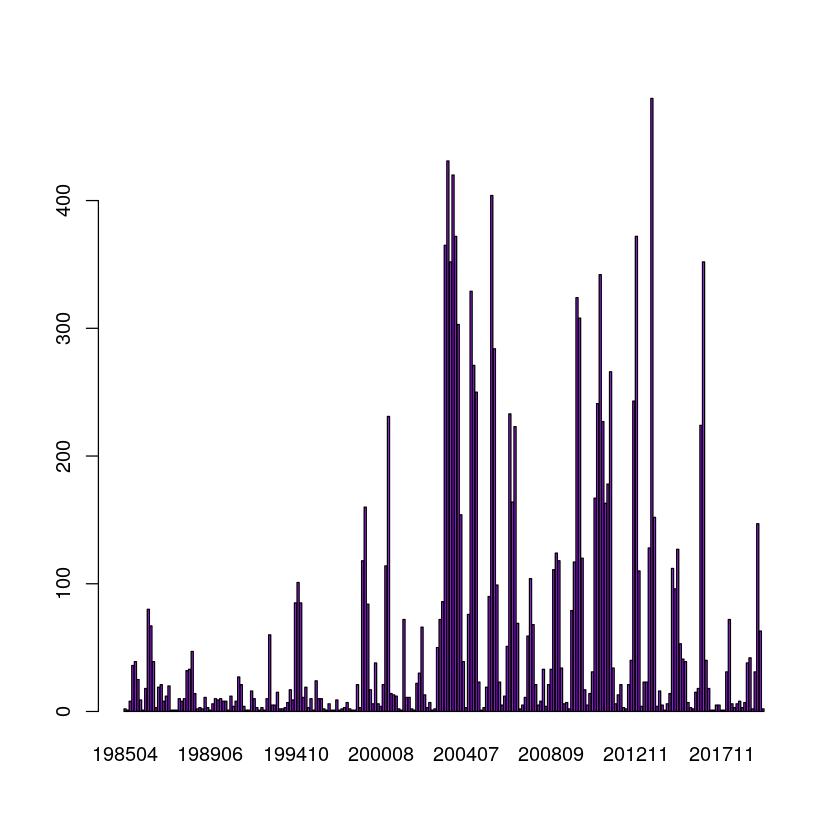

In [10]:
barplot(table(country_data$yearmonth), col= "purple")

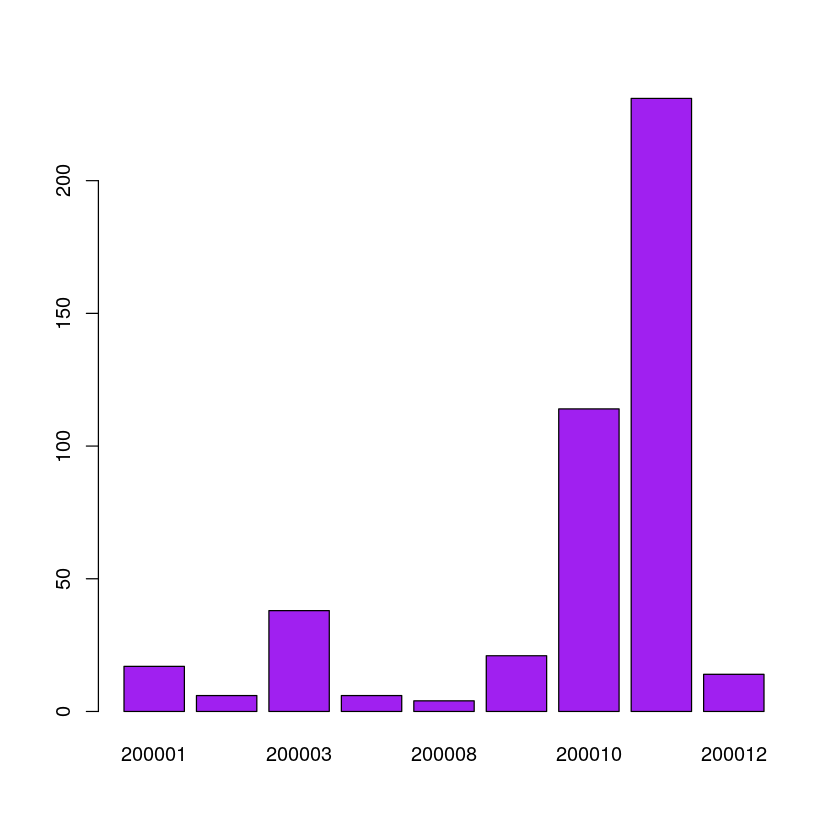

In [11]:
subset_year <- country_data[country_data$year == '2000',]
barplot(table(subset_year$yearmonth), col= "purple")

In [12]:
subset <- country_data[(country_data$yearmonth == '200011' & country_data$LOCPRESENT == 1),]

geo_locs <- data.frame(x=subset$X, y=subset$Y)
subset

,X,Y,OBJECTID,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,⋯,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,COUNTRY,yearmonth,year,month,day
,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
4512,-13.89944,19.15694,4512,2000/11/27 00:00:00+00,00:00,2000/11/27 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,27
4513,-13.91028,19.14444,4513,2000/11/27 00:00:00+00,00:00,2000/11/27 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,27
4514,-13.92306,19.14667,4514,2000/11/27 00:00:00+00,00:00,2000/11/27 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,27
4515,-12.94583,19.14639,4515,2000/11/28 00:00:00+00,00:00,2000/11/28 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,28
4516,-12.94972,19.13306,4516,2000/11/28 00:00:00+00,00:00,2000/11/28 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,28
4517,-13.94778,19.17194,4517,2000/11/29 00:00:00+00,00:00,2000/11/29 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,29
4518,-13.95194,19.19611,4518,2000/11/29 00:00:00+00,00:00,2000/11/29 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,29
4519,-13.87833,19.15500,4519,2000/11/29 00:00:00+00,00:00,2000/11/29 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,29
4520,-13.86917,19.15833,4520,2000/11/29 00:00:00+00,00:00,2000/11/29 00:00:00+00,00:00,Yes,NA,,⋯,0,0,0,0,Hopper,Mauritania,200011,2000,11,29


In [13]:
geo_locs

x,y
<dbl>,<dbl>
-13.89944,19.15694
-13.91028,19.14444
-13.92306,19.14667
-12.94583,19.14639
-12.94972,19.13306
-13.94778,19.17194
-13.95194,19.19611
-13.87833,19.15500
-13.86917,19.15833


## NASA Data

In [14]:
NASA_year <- 2000; NASA_month <- 10;
NASA_basePath <- '/mnt/disks/nasa/NASA'

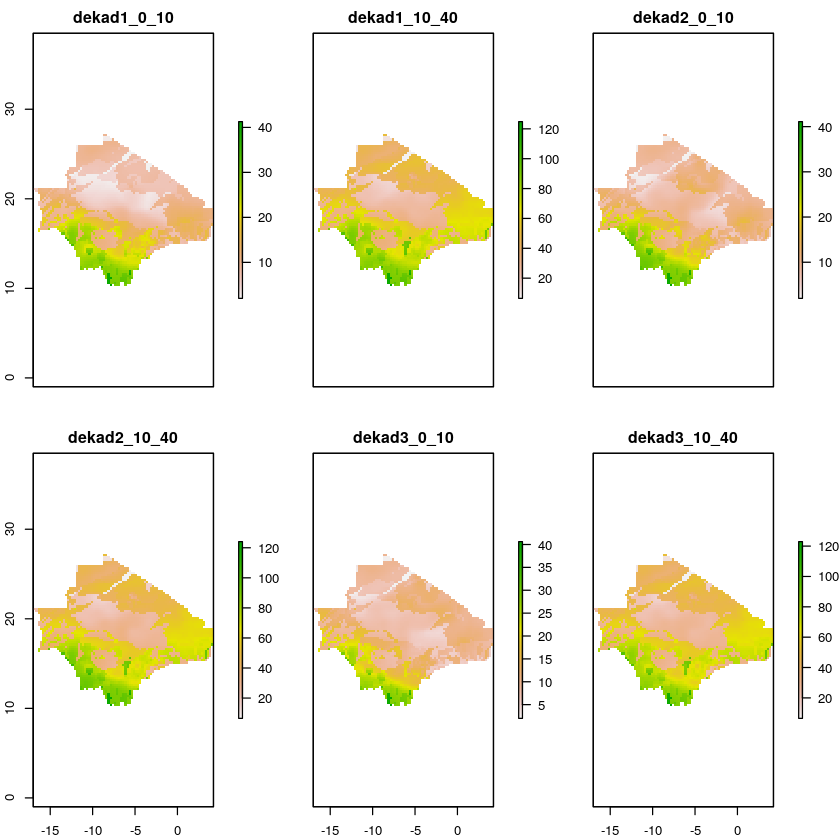

In [15]:
nasa_sm <- cropCountry(aggregateSM_NASA(NASA_year, NASA_month, NASA_basePath), country)
plot(nasa_sm)          

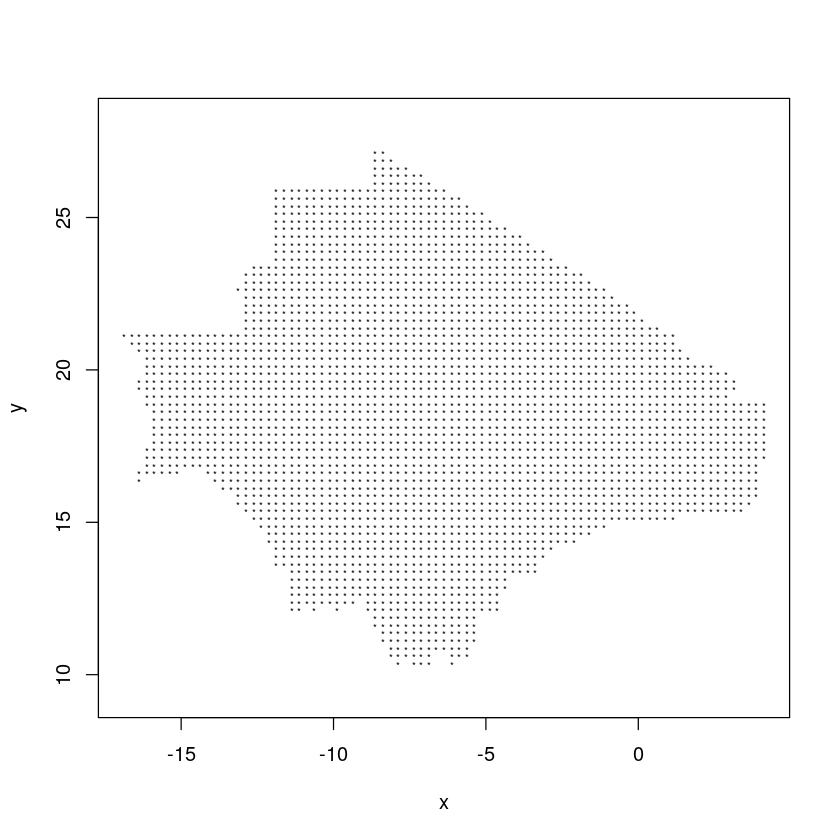

In [16]:
## Background of the whole study area
bg <- backgroundGrid(nasa_sm)
plot(bg$xy, pch = "*", asp = 1, cex = 0.5)

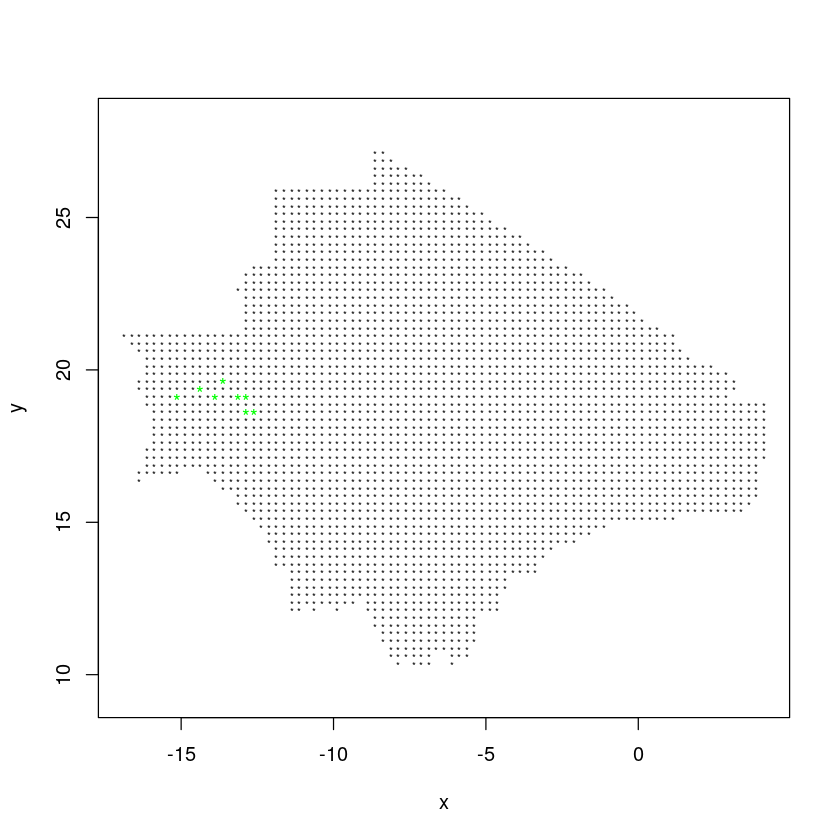

In [17]:
bg_profiled <- OCSVMprofiling(xy = geo_locs, varstack = nasa_sm, 
                              background = bg$xy)

plot(bg_profiled$absence, pch="*", asp = 1, cex = 0.5)
points(bg_profiled$presence, pch="*", col= "green")

In [71]:
bg_extents <- backgroundRadius(xy = geo_locs, background = bg$xy, 
                               start = 0.083*20, by = 0.083*20, 
                               unit = "decimal degrees")
nasa_random <-pseudoAbsences(xy = geo_locs, background = bg_extents, #[[1]]$km20, #bg$xy, 
                           exclusion.buffer = 0.083*1, 
                           prevalence = 0.5, kmeans = FALSE)

[1] "creating background point-grids for species 1 out of 1"


[2021-09-21 08:37:50] Generating pseudo-absences for species 1

:::[2021-09-21 08:37:50] Realization 1



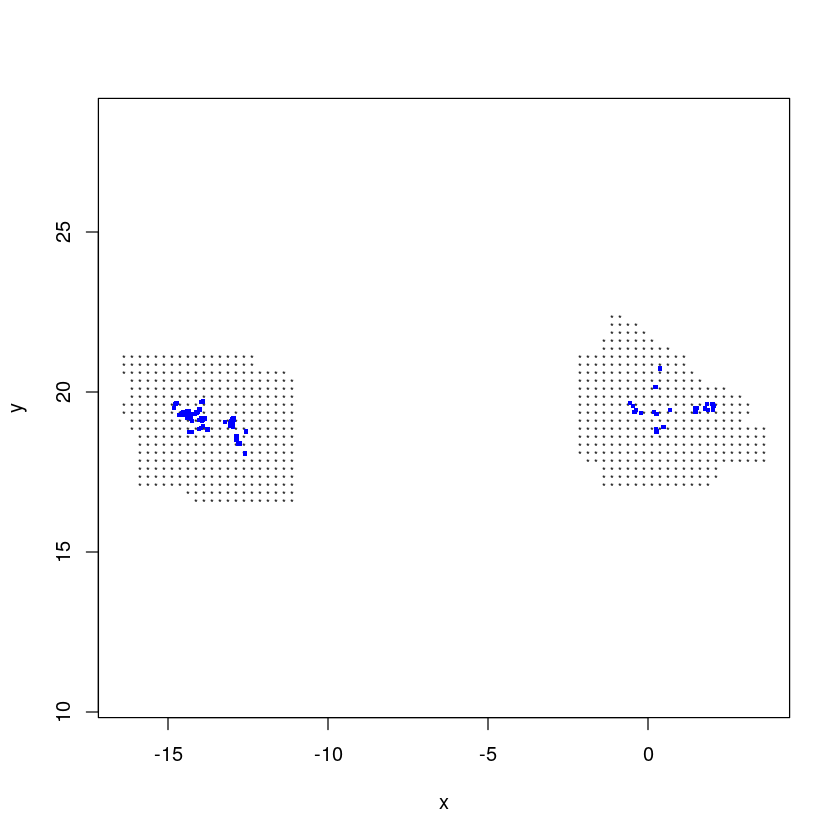

In [72]:
plot(bg_extents[[1]]$km200, pch = "*", asp = 1, cex = 0.5)
# points(filter(nasa_random$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(nasa_random$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

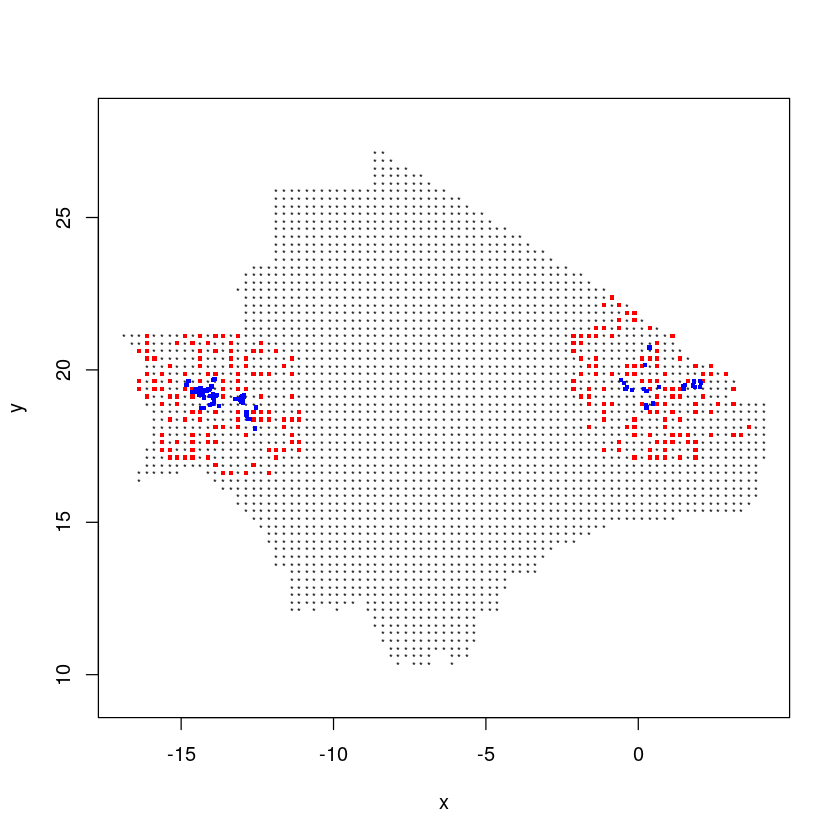

In [73]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.5)
points(filter(nasa_random$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(nasa_random$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

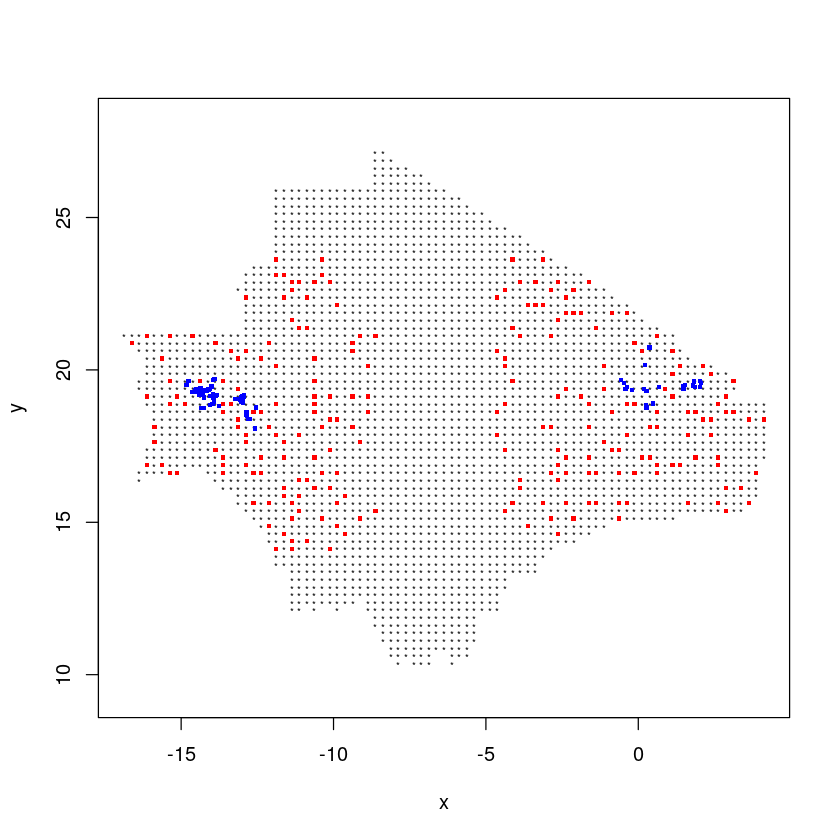

In [32]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.5)
points(filter(nasa_random$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(nasa_random$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

In [20]:
bg_extents <- backgroundRadius(xy = geo_locs, background = bg_profiled$absence, 
                               start = 0.083*5, by = 0.083*20, 
                               unit = "decimal degrees")
nasa_EP_random <-pseudoAbsences(xy = geo_locs, background = bg_extents, #bg_profiled$absence, 
                             exclusion.buffer = 0.083*1, 
                             prevalence = 0.5, kmeans = FALSE)

[1] "creating background point-grids for species 1 out of 1"


[2021-09-21 07:45:23] Generating pseudo-absences for species 1

:::[2021-09-21 07:45:23] Realization 1

Background km50 is too small for sampling and will be ignored



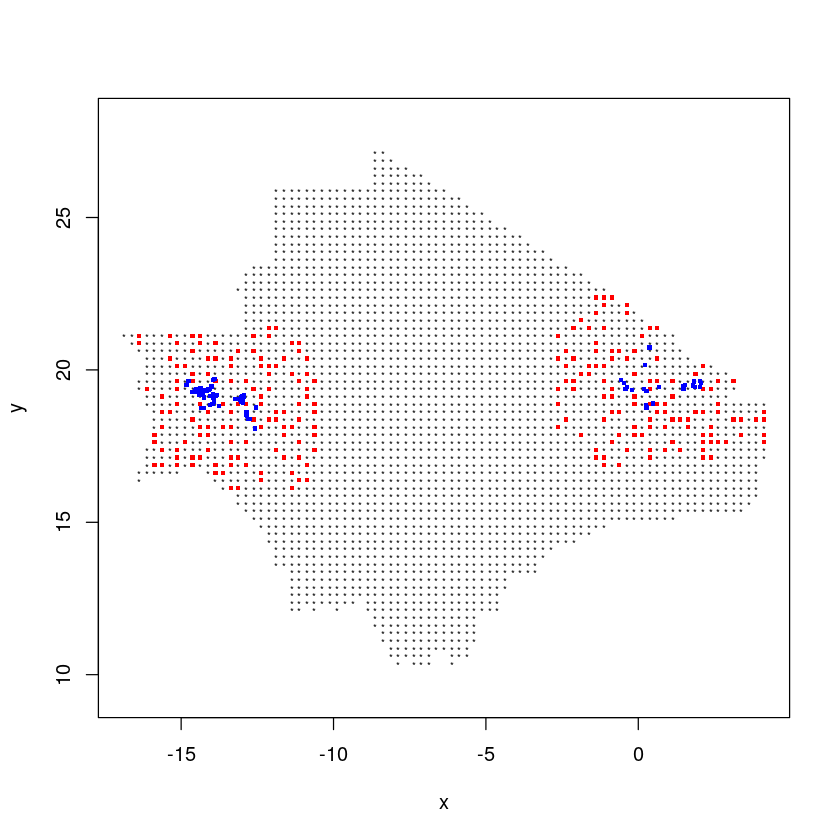

In [21]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.5)

points(filter(nasa_EP_random$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(nasa_EP_random$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

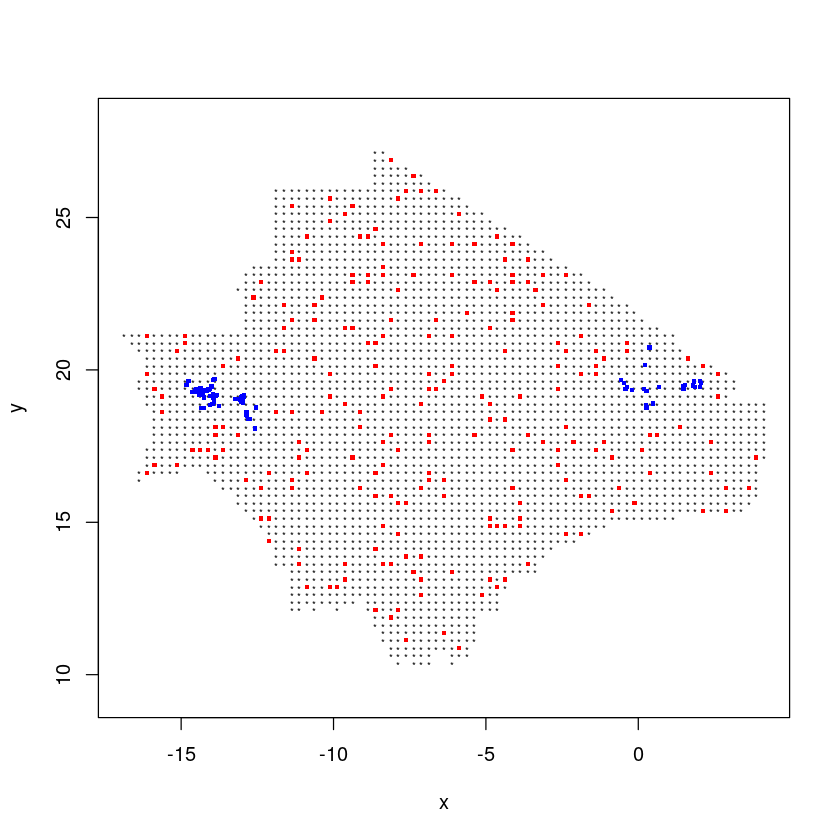

In [29]:
# plot(bg$xy, pch = "*", asp = 1, cex = 0.5)
# points(filter(nasa_EP_random$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
# points(filter(nasa_EP_random$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

In [29]:
bg_extents <- backgroundRadius(xy = geo_locs, background = bg_profiled$absence, 
                               start = 0.083*10, by = 0.083*20, 
                               unit = "decimal degrees")
nasa_kmeans <-pseudoAbsences(xy = geo_locs, background = bg_extents, 
                           exclusion.buffer = 0.083*1, 
                           prevalence = 0.5, kmeans = TRUE, 
                           varstack = nasa_sm)

[1] "creating background point-grids for species 1 out of 1"


[2021-09-21 07:48:35] Generating pseudo-absences for species 1

:::[2021-09-21 07:48:35] Realization 1



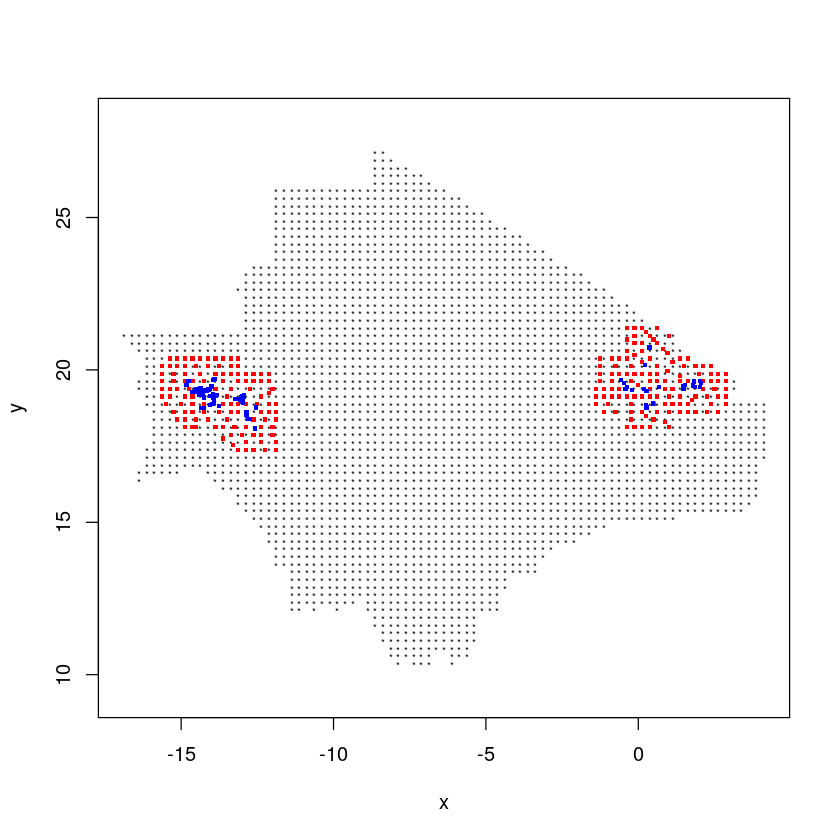

In [30]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.5)
points(filter(nasa_kmeans$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(nasa_kmeans$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

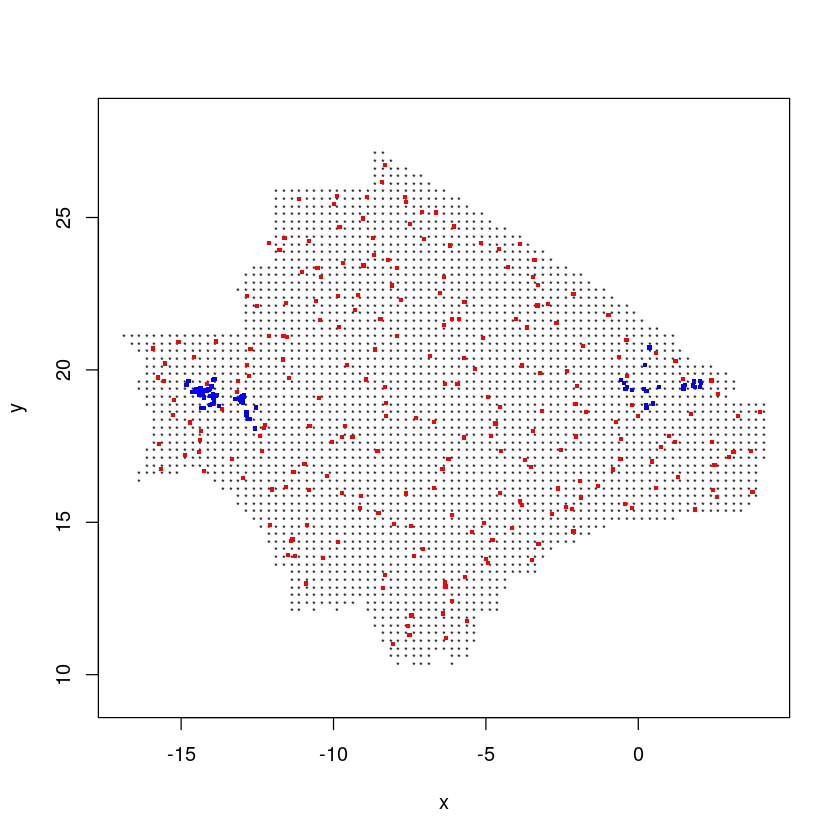

In [28]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.5)
points(filter(nasa_kmeans$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(nasa_kmeans$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

In [19]:
nasa_pa_generation <- function(yearmonths){

    dataframe_chunks <- list()
    i <- 1
    for (yearmonth in yearmonths){
        print(yearmonth)
        month <- yearmonth %% 100
        year <- yearmonth %/% 100
        
        success <- FALSE
        tryCatch({
            sm <- cropCountry(aggregateSM_NASA(year, month, NASA_basePath), country)
            env_data <- stack(sm, resample(soil_profile, sm))
            success <- TRUE
        }, error = function(e){
            print(paste('Error: ', e))
        })
        if (! success) next

        data_subset <- country_data[(country_data$yearmonth == as.character(yearmonth) & country_data$LOCPRESENT == 1),]
        geo_locs <- data.frame(x=data_subset$X, y=data_subset$Y)
        geo_locs_len <- dim(geo_locs)[1]
        bg <- backgroundGrid(env_data)
        
        success <- FALSE
        tryCatch({
            if (geo_locs_len < 1){
                next
            }
            else if ((geo_locs_len >= 1) & (geo_locs_len <= 5)){
                generated_data <- geo_locs
                generated_data['v'] = 1
            }
            else if ((geo_locs_len > 5) & (geo_locs_len < 100)) {
                # generate data randomly
                generated_data <-pseudoAbsences(xy = geo_locs, background = bg$xy, 
                                   exclusion.buffer = 0.083*5, 
                                   prevalence = 0.5, kmeans = FALSE)
            } else {
                bg_profiled <- OCSVMprofiling(xy = geo_locs, varstack = env_data, 
                                      background = bg$xy)
                # generate data using environmental profiling
#                 env_data[is.na(env_data)] <- 0
                generated_data <-pseudoAbsences(xy = geo_locs, background = bg_profiled$absence, 
                                   exclusion.buffer = 0.083*5, 
                                   prevalence = 0.5, kmeans = TRUE, 
                                   varstack = env_data)
            }
            success <- TRUE
        }, error = function(e){
            print(paste('Error: ', e))
        })
        if (! success) next
        
        final_data <- finalize_data(generated_data, data_subset, geo_locs_len <= 5)
        raster_data <- extract_values(data.frame(x=final_data$x, y=final_data$y), env_data)
        final_data <- cbind(final_data, raster_data)

        dataframe_chunks[[i]] <- final_data
        i <- i + 1
    }
    return(dplyr::bind_rows(dataframe_chunks))
}

In [20]:
print(nasa_yearmonths)

 [1] 200011 200001 200012 200010 200003 200002 200008 200004 200009 200101
[11] 200110 200111 200112 200102 200108 200109 200211 200212 200210 200201
[21] 200208 200209 200311 200312 200301 200302 200308 200309 200310 200401
[31] 200303 200307 200412 200411 200410 200406 200408 200402 200404 200403
[41] 200409 200405 200407 200512 200511 200508 200509 200510 200601 200507
[51] 200612 200610 200611 200608 200609 200604 200602 200603 200712 200701
[61] 200711 200709 200710 200801 200702 200812 200811 200804 200803 200805
[71] 200802 200810 200809 200808 200901 200910 200909 200911 200912 200908
[81] 200907 200902 200903 201011 201010 201012 201008 201009 201001 201002


In [21]:
nasa_dataset <- nasa_pa_generation(nasa_yearmonths)

[1] 200011


[2021-09-13 20:26:21] Generating pseudo-absences for species 1

:::[2021-09-13 20:26:21] Realization 1



[1] 200001


[2021-09-13 20:29:12] Generating pseudo-absences for species 1

:::[2021-09-13 20:29:12] Realization 1



[1] 200012


[2021-09-13 20:31:54] Generating pseudo-absences for species 1

:::[2021-09-13 20:31:54] Realization 1



[1] 200003


[2021-09-13 20:37:20] Generating pseudo-absences for species 1

:::[2021-09-13 20:37:20] Realization 1



[1] 200002


[2021-09-13 20:39:55] Generating pseudo-absences for species 1

:::[2021-09-13 20:39:55] Realization 1



[1] 200008
[1] 200004


[2021-09-13 20:45:27] Generating pseudo-absences for species 1

:::[2021-09-13 20:45:27] Realization 1



[1] 200009


[2021-09-13 20:48:16] Generating pseudo-absences for species 1

:::[2021-09-13 20:48:16] Realization 1



[1] 200101


[2021-09-13 20:51:16] Generating pseudo-absences for species 1

:::[2021-09-13 20:51:16] Realization 1



[1] 200110


[2021-09-13 20:54:19] Generating pseudo-absences for species 1

:::[2021-09-13 20:54:19] Realization 1



[1] 200111


[2021-09-13 20:57:18] Generating pseudo-absences for species 1

:::[2021-09-13 20:57:18] Realization 1



[1] 200112


[2021-09-13 21:00:16] Generating pseudo-absences for species 1

:::[2021-09-13 21:00:16] Realization 1



[1] 200102


[2021-09-13 21:03:01] Generating pseudo-absences for species 1

:::[2021-09-13 21:03:01] Realization 1



[1] 200108
[1] 200109
[1] 200211


[2021-09-13 21:12:01] Generating pseudo-absences for species 1

:::[2021-09-13 21:12:01] Realization 1



[1] 200212


[2021-09-13 21:15:13] Generating pseudo-absences for species 1

:::[2021-09-13 21:15:13] Realization 1



[1] 200210


[2021-09-13 21:18:24] Generating pseudo-absences for species 1

:::[2021-09-13 21:18:24] Realization 1



[1] 200201
[1] "Error:  Error in .local(x, ...): no filenames supplied\n"
[1] 200208
[1] 200209


[2021-09-13 21:25:42] Generating pseudo-absences for species 1

:::[2021-09-13 21:25:42] Realization 1



[1] 200311


[2021-09-13 21:28:49] Generating pseudo-absences for species 1

:::[2021-09-13 21:28:49] Realization 1



[1] 200312


[2021-09-13 21:32:04] Generating pseudo-absences for species 1

:::[2021-09-13 21:32:04] Realization 1



[1] 200301
[1] 200302


[2021-09-13 21:38:17] Generating pseudo-absences for species 1

:::[2021-09-13 21:38:17] Realization 1



[1] 200308


[2021-09-13 21:41:34] Generating pseudo-absences for species 1

:::[2021-09-13 21:41:34] Realization 1



[1] 200309


[2021-09-13 21:44:49] Generating pseudo-absences for species 1

:::[2021-09-13 21:44:49] Realization 1



[1] 200310


[2021-09-13 21:48:12] Generating pseudo-absences for species 1

:::[2021-09-13 21:48:12] Realization 1



[1] 200401


[2021-09-13 21:51:38] Generating pseudo-absences for species 1

:::[2021-09-13 21:51:38] Realization 1



[1] 200303
[1] 200307
[1] 200412


[2021-09-13 22:02:04] Generating pseudo-absences for species 1

:::[2021-09-13 22:02:04] Realization 1



[1] 200411


[2021-09-13 22:05:29] Generating pseudo-absences for species 1

:::[2021-09-13 22:05:29] Realization 1



[1] 200410


[2021-09-13 22:09:02] Generating pseudo-absences for species 1

:::[2021-09-13 22:09:02] Realization 1



[1] 200406


[2021-09-13 22:12:32] Generating pseudo-absences for species 1

:::[2021-09-13 22:12:32] Realization 1



[1] 200408


[2021-09-13 22:16:10] Generating pseudo-absences for species 1

:::[2021-09-13 22:16:10] Realization 1



[1] 200402


[2021-09-13 22:19:35] Generating pseudo-absences for species 1

:::[2021-09-13 22:19:35] Realization 1



[1] 200404


[2021-09-13 22:23:13] Generating pseudo-absences for species 1

:::[2021-09-13 22:23:13] Realization 1



[1] 200403


[2021-09-13 22:26:58] Generating pseudo-absences for species 1

:::[2021-09-13 22:26:58] Realization 1



[1] 200409


[2021-09-13 22:30:40] Generating pseudo-absences for species 1

:::[2021-09-13 22:30:40] Realization 1



[1] 200405


[2021-09-13 22:34:30] Generating pseudo-absences for species 1

:::[2021-09-13 22:34:30] Realization 1



[1] 200407
[1] 200512


[2021-09-13 22:42:10] Generating pseudo-absences for species 1

:::[2021-09-13 22:42:10] Realization 1



[1] 200511


[2021-09-13 22:45:56] Generating pseudo-absences for species 1

:::[2021-09-13 22:45:56] Realization 1



[1] 200508
[1] 200509


[2021-09-13 22:53:42] Generating pseudo-absences for species 1

:::[2021-09-13 22:53:42] Realization 1



[1] 200510


[2021-09-13 22:57:41] Generating pseudo-absences for species 1

:::[2021-09-13 22:57:41] Realization 1



[1] 200601


[2021-09-13 23:01:41] Generating pseudo-absences for species 1

:::[2021-09-13 23:01:41] Realization 1



[1] 200507
[1] 200612


[2021-09-13 23:09:48] Generating pseudo-absences for species 1

:::[2021-09-13 23:09:48] Realization 1



[1] 200610


[2021-09-13 23:13:54] Generating pseudo-absences for species 1

:::[2021-09-13 23:13:54] Realization 1



[1] 200611


[2021-09-13 23:17:55] Generating pseudo-absences for species 1

:::[2021-09-13 23:17:55] Realization 1



[1] 200608


[2021-09-13 23:22:07] Generating pseudo-absences for species 1

:::[2021-09-13 23:22:08] Realization 1



[1] 200604


[2021-09-13 23:30:15] Generating pseudo-absences for species 1

:::[2021-09-13 23:30:15] Realization 1



[1] 200602


[2021-09-13 23:34:06] Generating pseudo-absences for species 1

:::[2021-09-13 23:34:06] Realization 1



[1] 200603
[1] 200712


[2021-09-13 23:42:55] Generating pseudo-absences for species 1

:::[2021-09-13 23:42:55] Realization 1



[1] 200701
[1] 200711


[2021-09-13 23:51:47] Generating pseudo-absences for species 1

:::[2021-09-13 23:51:47] Realization 1



[1] 200709


[2021-09-13 23:56:11] Generating pseudo-absences for species 1

:::[2021-09-13 23:56:11] Realization 1



[1] 200710


[2021-09-14 00:00:52] Generating pseudo-absences for species 1

:::[2021-09-14 00:00:52] Realization 1



[1] 200801


[2021-09-14 00:05:36] Generating pseudo-absences for species 1

:::[2021-09-14 00:05:36] Realization 1



[1] 200702
[1] 200812


[2021-09-14 00:14:53] Generating pseudo-absences for species 1

:::[2021-09-14 00:14:53] Realization 1



[1] 200811


[2021-09-14 00:19:42] Generating pseudo-absences for species 1

:::[2021-09-14 00:19:42] Realization 1



[1] 200804


[2021-09-14 00:24:35] Generating pseudo-absences for species 1

:::[2021-09-14 00:24:35] Realization 1



[1] 200803


[2021-09-14 00:29:41] Generating pseudo-absences for species 1

:::[2021-09-14 00:29:41] Realization 1



[1] 200805
[1] 200802
[1] 200810


[2021-09-14 00:44:58] Generating pseudo-absences for species 1

:::[2021-09-14 00:44:58] Realization 1



[1] 200809


[2021-09-14 00:50:09] Generating pseudo-absences for species 1

:::[2021-09-14 00:50:09] Realization 1



[1] 200808


[2021-09-14 00:55:35] Generating pseudo-absences for species 1

:::[2021-09-14 00:55:35] Realization 1



[1] 200901


[2021-09-14 01:01:02] Generating pseudo-absences for species 1

:::[2021-09-14 01:01:02] Realization 1



[1] 200910


[2021-09-14 01:06:32] Generating pseudo-absences for species 1

:::[2021-09-14 01:06:32] Realization 1



[1] 200909


[2021-09-14 01:11:56] Generating pseudo-absences for species 1

:::[2021-09-14 01:11:56] Realization 1



[1] 200911


[2021-09-14 01:17:26] Generating pseudo-absences for species 1

:::[2021-09-14 01:17:26] Realization 1



[1] 200912


[2021-09-14 01:23:12] Generating pseudo-absences for species 1

:::[2021-09-14 01:23:12] Realization 1



[1] 200908


[2021-09-14 01:29:02] Generating pseudo-absences for species 1

:::[2021-09-14 01:29:02] Realization 1



[1] 200907
[1] 200902


[2021-09-14 01:40:16] Generating pseudo-absences for species 1

:::[2021-09-14 01:40:16] Realization 1



[1] 200903


[2021-09-14 01:46:11] Generating pseudo-absences for species 1

:::[2021-09-14 01:46:11] Realization 1



[1] 201011


[2021-09-14 01:52:04] Generating pseudo-absences for species 1

:::[2021-09-14 01:52:04] Realization 1



[1] 201010


[2021-09-14 01:58:09] Generating pseudo-absences for species 1

:::[2021-09-14 01:58:09] Realization 1



[1] 201012


[2021-09-14 02:04:18] Generating pseudo-absences for species 1

:::[2021-09-14 02:04:18] Realization 1



[1] 201008


[2021-09-14 02:10:37] Generating pseudo-absences for species 1

:::[2021-09-14 02:10:37] Realization 1



[1] 201009


[2021-09-14 02:16:46] Generating pseudo-absences for species 1

:::[2021-09-14 02:16:46] Realization 1



[1] 201001


[2021-09-14 02:23:10] Generating pseudo-absences for species 1

:::[2021-09-14 02:23:10] Realization 1



[1] 201002


In [22]:
write.csv(nasa_dataset,'nasa_dataset_v2.csv')

In [56]:
dim(nasa_dataset[nasa_dataset$country=='Mauritania',])

[1] 15956    19

In [57]:
dim(nasa_dataset[nasa_dataset$country=='Mali',])

[1] 1030   19

## SMELLS Dataset

In [23]:
SMELLS_year <- 2018; SMELLS_month <- 01; 
SMELLS_basePath <- 'SMELLS Dataset'

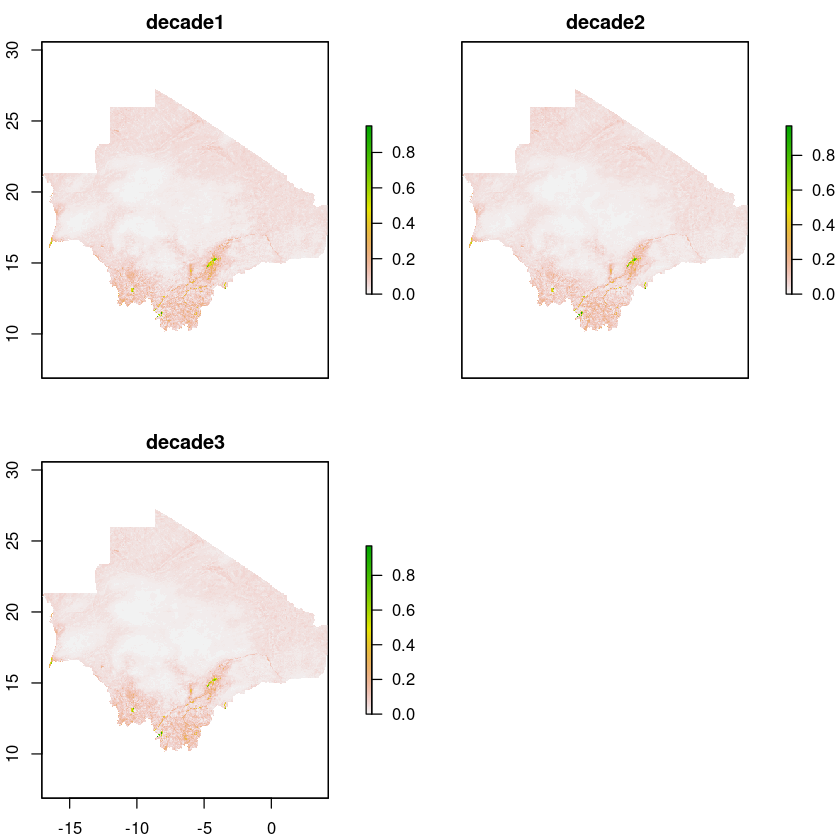

In [26]:
smells_sm <- cropCountry(aggregateSM_SMELLS(SMELLS_year, SMELLS_month, 'SMELLS Dataset'), country)
smells_sm <- calc(smells_sm, fun=function(x){ x[x > 1.0] <- 0; return(x)} )
projection(smells_sm) <- CRS("+proj=longlat +init=epsg:4326")

plot(smells_sm)

In [27]:
smells_sm

class      : RasterBrick 
dimensions : 1714, 2131, 3652534, 3  (nrow, ncol, ncell, nlayers)
resolution : 0.01, 0.01  (x, y)
extent     : -17.07, 4.24, 10.16, 27.3  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : decade1, decade2, decade3 
min values :       0,       0,       0 
max values :    0.99,    0.99,    0.99 


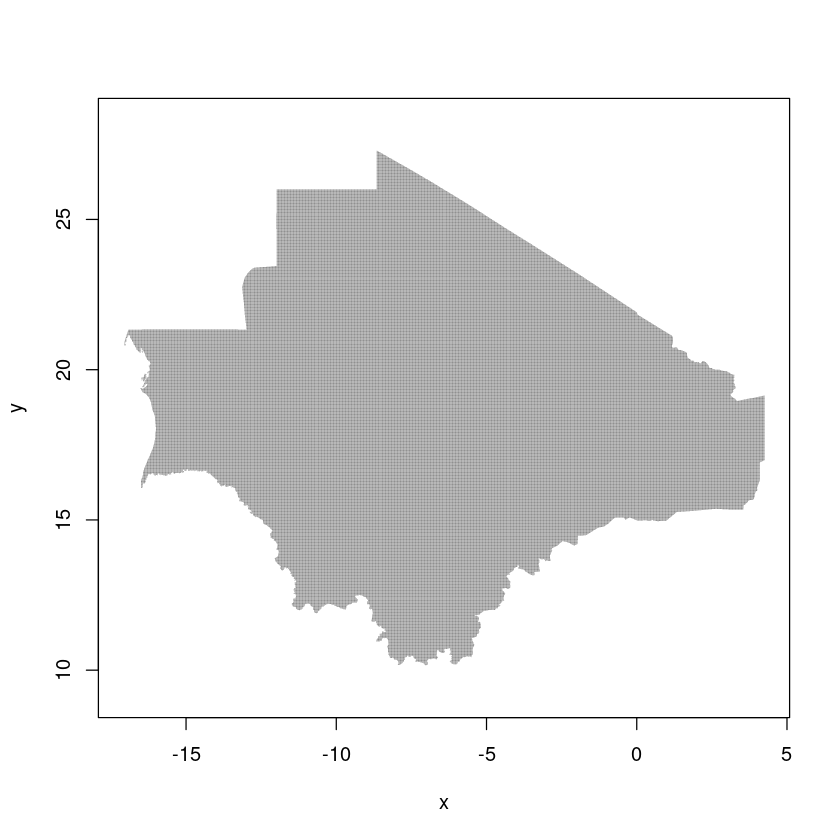

In [28]:
## Environmental profiling of the background

bg <- backgroundGrid(smells_sm)
plot(bg$xy, pch = "*", asp = 1, cex = 0.05)

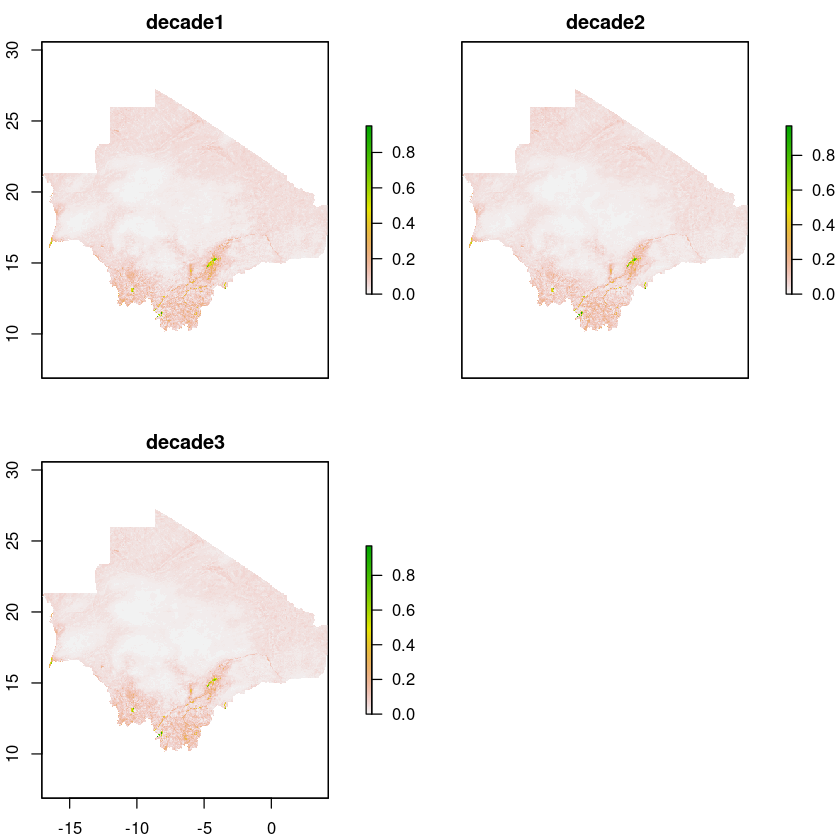

In [29]:
smells_sm <- cropCountry(aggregateSM_SMELLS(2018, 1, 'SMELLS Dataset'), country)
smells_sm <- calc(smells_sm, fun=function(x){ x[x > 1.0] <- 0; return(x)} )
projection(smells_sm) <- CRS("+proj=longlat +init=epsg:4326")

plot(smells_sm)

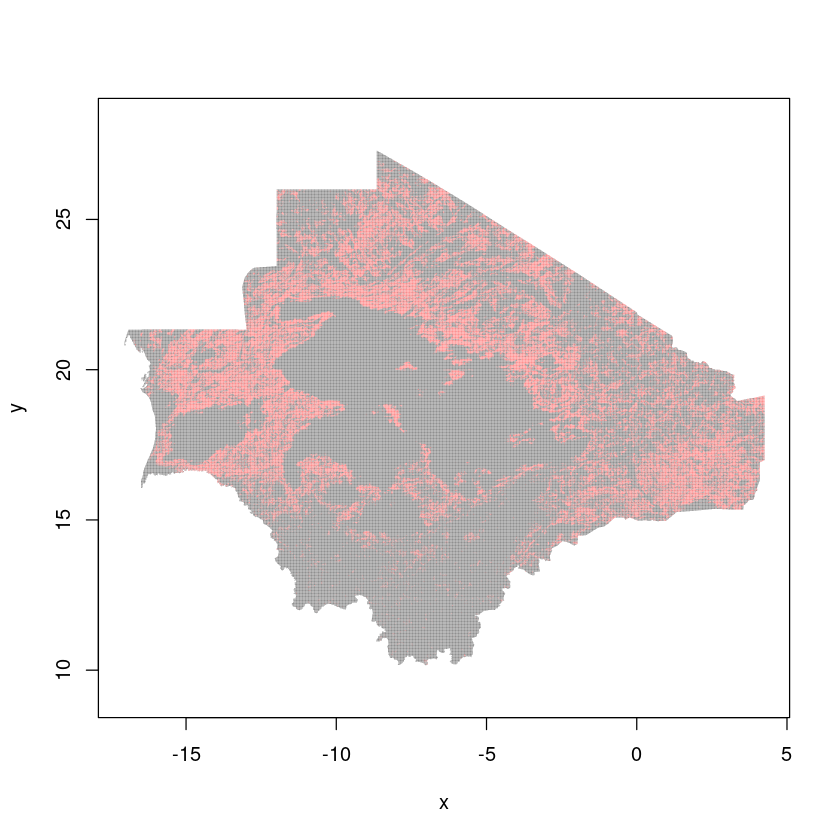

In [30]:
bg_profiled <- OCSVMprofiling(xy = geo_locs, varstack = smells_sm, 
                              background = bg$xy)

plot(bg_profiled$absence, pch="*", asp = 1, cex = 0.05)
points(bg_profiled$presence, pch="*", col= "red", cex = 0.05)

In [31]:
smells_random <-pseudoAbsences(xy = geo_locs, background = bg$xy, 
                           exclusion.buffer = 0.083*5, 
                           prevalence = 0.5, kmeans = FALSE)

[2021-09-09 18:16:29] Generating pseudo-absences for species 1

:::[2021-09-09 18:16:29] Realization 1



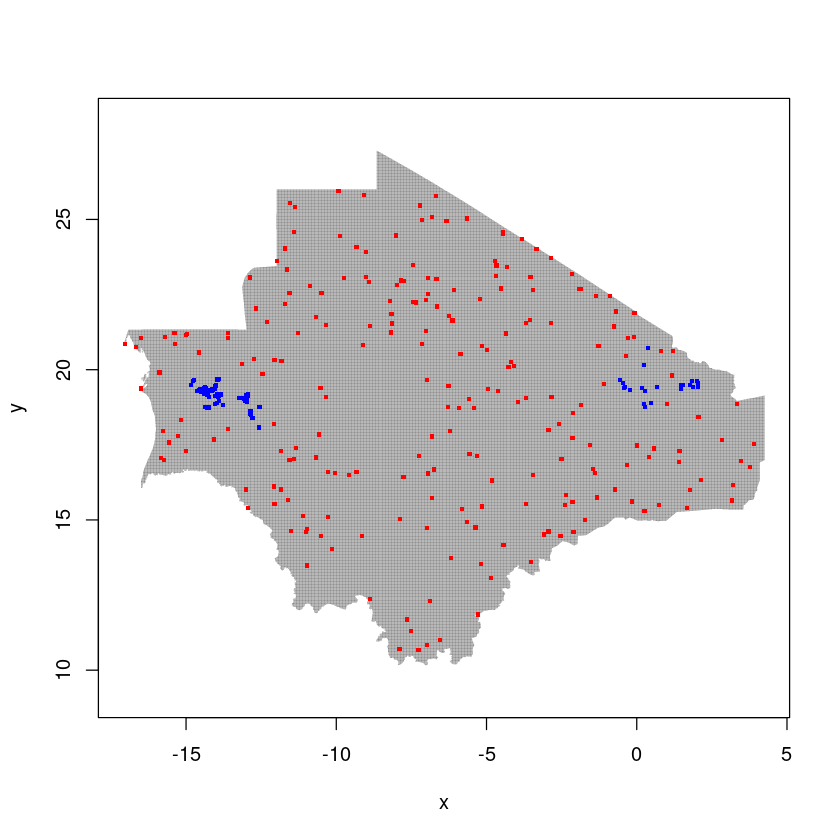

In [32]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.05)
points(filter(smells_random$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(smells_random$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

In [33]:
smells_EP_random <-pseudoAbsences(xy = geo_locs, background = bg_profiled$absence, 
                             exclusion.buffer = 0.083*5, 
                             prevalence = 0.5, kmeans = FALSE)

[2021-09-09 18:18:05] Generating pseudo-absences for species 1

:::[2021-09-09 18:18:05] Realization 1



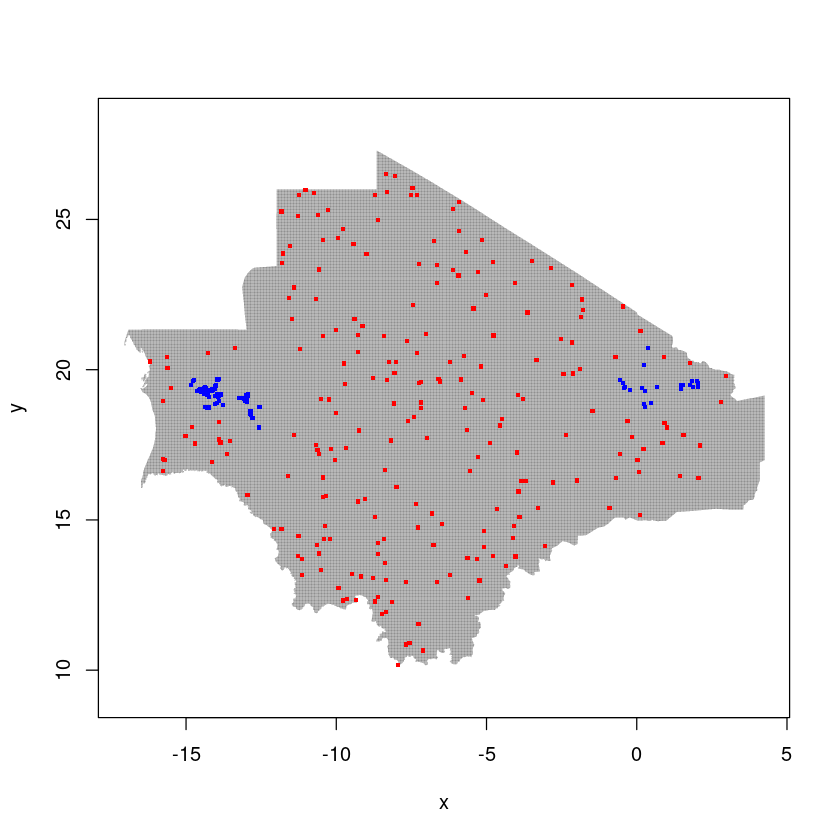

In [34]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.05)
points(filter(smells_EP_random$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(smells_EP_random$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

In [35]:
smells_kmeans <-pseudoAbsences(xy = geo_locs, background = bg_profiled$absence, 
                           exclusion.buffer = 0.083*5, 
                           prevalence = 0.5, kmeans = TRUE, 
                           varstack = smells_sm)

[2021-09-09 18:19:43] Generating pseudo-absences for species 1

:::[2021-09-09 18:19:43] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 71030800)”


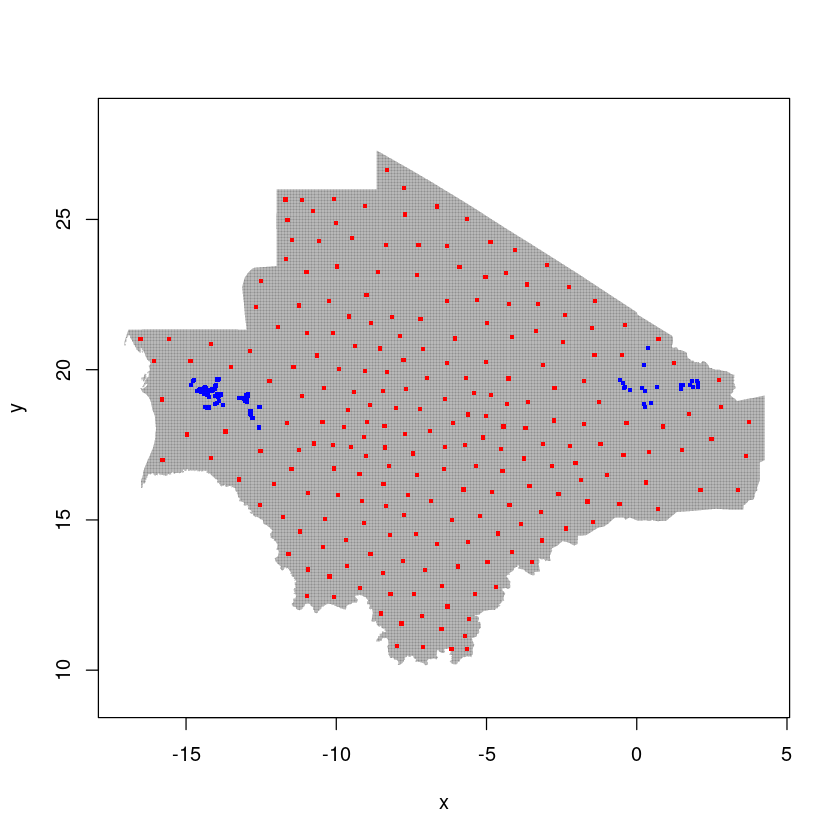

In [36]:
plot(bg$xy, pch = "*", asp = 1, cex = 0.05)
points(filter(smells_kmeans$species1$PA01[[1]], v == 0), col= "red", pch = ".", cex = 3.5)
points(filter(smells_kmeans$species1$PA01[[1]], v == 1), col= "blue", pch = ".", cex = 3.5)

In [53]:
2 != 3

[1] TRUE

In [24]:
smells_pa_generation <- function(yearmonths){

    dataframe_chunks <- list()
    i <- 1
    for (yearmonth in yearmonths){
        print(yearmonth)
        month <- yearmonth %% 100
        year <- yearmonth %/% 100
        
        success <- FALSE
        tryCatch({
            sm <- cropCountry(aggregateSM_SMELLS(year, month, SMELLS_basePath), country)
            if (nlayers(sm) != 3) next
            sm <- calc(sm, fun=function(x){ x[x > 1.0] <- 0; return(x)})
            projection(sm) <- CRS("+proj=longlat +init=epsg:4326")
            extent(soil_profile) <- extent(sm)
            env_data <- stack(sm, soil_profile)
            
            success <- TRUE
        }, error = function(e){
            print(paste('Error: ', e))
        })
        if (! success) next
        
        data_subset <- country_data[(country_data$yearmonth == as.character(yearmonth) & country_data$LOCPRESENT == 1),]
        geo_locs <- data.frame(x=data_subset$X, y=data_subset$Y)
        geo_locs_len <- dim(geo_locs)[1]
        bg <- backgroundGrid(env_data)

        success <- FALSE
        tryCatch({
            if (geo_locs_len < 1){
                next
            }
            else if ((geo_locs_len >= 1) & (geo_locs_len <= 5)){
                generated_data <- geo_locs
                generated_data['v'] = 1
            }
            else if ((geo_locs_len > 5) & (geo_locs_len < 100)) {
                # generate data randomly
                generated_data <-pseudoAbsences(xy = geo_locs, background = bg$xy, 
                                   exclusion.buffer = 0.083*5, 
                                   prevalence = 0.5, kmeans = FALSE)
            } else {
                bg_profiled <- OCSVMprofiling(xy = geo_locs, varstack = env_data, 
                                      background = bg$xy)
                # generate data using environmental profiling
#                 env_data[is.na(env_data)] <- 0
                generated_data <-pseudoAbsences(xy = geo_locs, background = bg_profiled$absence, 
                                   exclusion.buffer = 0.083*5, 
                                   prevalence = 0.5, kmeans = TRUE, 
                                   varstack = env_data)
            }
            success <- TRUE
        }, error = function(e){
            print(paste('Error: ', e))
        })
        if (! success) next
        
        final_data <- finalize_data(generated_data, data_subset, geo_locs_len <= 5)
        raster_data <- extract_values(data.frame(x=final_data$x, y=final_data$y), env_data)
        final_data <- cbind(final_data, raster_data)

        dataframe_chunks[[i]] <- final_data
        i <- i + 1
    }
    return(dplyr::bind_rows(dataframe_chunks))
}

In [25]:
print(smells_yearmonths)

 [1] 201011 201010 201012 201008 201009 201001 201002 201101 201103 201102
[11] 201104 201105 201109 201111 201108 201110 201211 201212 201210 201208
[21] 201207 201209 201301 201311 201310 201312 201308 201309 201409 201410
[31] 201411 201412 201510 201511 201512 201509 201610 201603 201609 201611
[41] 201604 201605 201602 201601 201606 201607 201608 201612 201701 201702
[51] 201709 201712 201710 201711 201707


In [26]:
smells_dataset <- smells_pa_generation(smells_yearmonths)

[1] 201011


[2021-09-14 02:29:56] Generating pseudo-absences for species 1

:::[2021-09-14 02:29:56] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 80261600)”


[1] 201010


[2021-09-14 02:30:56] Generating pseudo-absences for species 1

:::[2021-09-14 02:30:56] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 86327750)”


[1] 201012


[2021-09-14 02:32:04] Generating pseudo-absences for species 1

:::[2021-09-14 02:32:04] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 89846400)”


[1] 201008


[2021-09-14 02:32:59] Generating pseudo-absences for species 1

:::[2021-09-14 02:32:59] Realization 1



[1] 201009


[2021-09-14 02:33:46] Generating pseudo-absences for species 1

:::[2021-09-14 02:33:46] Realization 1



[1] 201001
[1] "Error:  Error in `names<-`(`*tmp*`, value = c(\"dekad1\", \"dekad2\", \"dekad3\")): incorrect number of layer names\n"
[1] 201002
[1] 201101


[2021-09-14 02:35:33] Generating pseudo-absences for species 1

:::[2021-09-14 02:35:33] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 92608150)”


[1] 201103


[2021-09-14 02:36:36] Generating pseudo-absences for species 1

:::[2021-09-14 02:36:36] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 93527850)”


[1] 201102


[2021-09-14 02:37:40] Generating pseudo-absences for species 1

:::[2021-09-14 02:37:40] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 92994800)”


[1] 201104


[2021-09-14 02:38:45] Generating pseudo-absences for species 1

:::[2021-09-14 02:38:45] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 94732950)”


[1] 201105


[2021-09-14 02:39:39] Generating pseudo-absences for species 1

:::[2021-09-14 02:39:39] Realization 1



[1] 201109


[2021-09-14 02:40:23] Generating pseudo-absences for species 1

:::[2021-09-14 02:40:23] Realization 1



[1] 201111
[1] 201108


[2021-09-14 02:41:51] Generating pseudo-absences for species 1

:::[2021-09-14 02:41:51] Realization 1



[1] 201110


[2021-09-14 02:42:35] Generating pseudo-absences for species 1

:::[2021-09-14 02:42:35] Realization 1



[1] 201211


[2021-09-14 02:43:38] Generating pseudo-absences for species 1

:::[2021-09-14 02:43:38] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 79265700)”


[1] 201212


[2021-09-14 02:44:42] Generating pseudo-absences for species 1

:::[2021-09-14 02:44:42] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 89094000)”


[1] 201210


[2021-09-14 02:45:48] Generating pseudo-absences for species 1

:::[2021-09-14 02:45:48] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 76953750)”


[1] 201208


[2021-09-14 02:46:45] Generating pseudo-absences for species 1

:::[2021-09-14 02:46:45] Realization 1



[1] 201207
[1] 201209


[2021-09-14 02:48:14] Generating pseudo-absences for species 1

:::[2021-09-14 02:48:14] Realization 1



[1] 201301
[1] 201311


[2021-09-14 02:50:06] Generating pseudo-absences for species 1

:::[2021-09-14 02:50:06] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 89642200)”


[1] 201310


[2021-09-14 02:51:21] Generating pseudo-absences for species 1

:::[2021-09-14 02:51:21] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 83146650)”


[1] 201312


[2021-09-14 02:52:23] Generating pseudo-absences for species 1

:::[2021-09-14 02:52:23] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 95615500)”


[1] 201308


[2021-09-14 02:53:15] Generating pseudo-absences for species 1

:::[2021-09-14 02:53:15] Realization 1



[1] 201309


[2021-09-14 02:54:00] Generating pseudo-absences for species 1

:::[2021-09-14 02:54:00] Realization 1



[1] 201409
[1] 201410


[2021-09-14 02:55:32] Generating pseudo-absences for species 1

:::[2021-09-14 02:55:32] Realization 1



[1] 201411
[1] 201412
[1] 201510


[2021-09-14 02:57:44] Generating pseudo-absences for species 1

:::[2021-09-14 02:57:44] Realization 1



[1] 201511


[2021-09-14 02:58:39] Generating pseudo-absences for species 1

:::[2021-09-14 02:58:39] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 91884300)”


[1] 201512


[2021-09-14 02:59:32] Generating pseudo-absences for species 1

:::[2021-09-14 02:59:32] Realization 1



[1] 201509


[2021-09-14 03:00:22] Generating pseudo-absences for species 1

:::[2021-09-14 03:00:22] Realization 1



[1] 201610


[2021-09-14 03:01:20] Generating pseudo-absences for species 1

:::[2021-09-14 03:01:20] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 87736600)”


[1] 201603


[2021-09-14 03:02:16] Generating pseudo-absences for species 1

:::[2021-09-14 03:02:16] Realization 1



[1] 201609


[2021-09-14 03:03:04] Generating pseudo-absences for species 1

:::[2021-09-14 03:03:04] Realization 1



[1] 201611


[2021-09-14 03:04:07] Generating pseudo-absences for species 1

:::[2021-09-14 03:04:07] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 91033250)”


[1] 201604


[2021-09-14 03:05:07] Generating pseudo-absences for species 1

:::[2021-09-14 03:05:07] Realization 1



[1] 201605


[2021-09-14 03:05:54] Generating pseudo-absences for species 1

:::[2021-09-14 03:05:54] Realization 1



[1] 201602
[1] "Error:  Error in `names<-`(`*tmp*`, value = c(\"dekad1\", \"dekad2\", \"dekad3\")): incorrect number of layer names\n"
[1] 201601


[2021-09-14 03:07:02] Generating pseudo-absences for species 1

:::[2021-09-14 03:07:02] Realization 1

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 92247650)”


[1] 201606
[1] 201607
[1] 201608


[2021-09-14 03:09:27] Generating pseudo-absences for species 1

:::[2021-09-14 03:09:27] Realization 1



[1] 201612


[2021-09-14 03:10:17] Generating pseudo-absences for species 1

:::[2021-09-14 03:10:17] Realization 1



[1] 201701


[2021-09-14 03:11:03] Generating pseudo-absences for species 1

:::[2021-09-14 03:11:03] Realization 1



[1] 201702
[1] 201709
[1] 201712
[1] 201710
[1] 201711
[1] 201707


In [28]:
smells_dataset

x,y,presence,year,month,day,country,dekad1,dekad2,dekad3,clay_0.5cm_mean,clay_5.15cm_mean,sand_0.5cm_mean,sand_5.15cm_mean,silt_0.5cm_mean,silt_5.15cm_mean
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-12.95472,19.78806,1,2010,11,27,Mauritania,0.02344136,0.03000000,0.03000000,0.1666181,0.1644622,0.6078140,0.6148387,0.2255679,0.2204020
-13.07000,19.98944,1,2010,11,28,Mauritania,0.02500000,0.02277778,0.03000000,0.1825000,0.1799444,0.6003333,0.6040000,0.2171667,0.2158333
-13.08583,19.99028,1,2010,11,29,Mauritania,0.03516204,0.03039352,0.03083333,0.1882685,0.1901250,0.5979560,0.5995718,0.2137755,0.2102593
-13.08639,19.99306,1,2010,11,14,Mauritania,0.03306327,0.03027006,0.03138889,0.1844784,0.1856435,0.5947400,0.5956582,0.2207816,0.2185864
-13.08611,19.99278,1,2010,11,20,Mauritania,0.03308642,0.03024691,0.03111111,0.1854691,0.1867407,0.5946543,0.5957160,0.2198765,0.2174568
-13.11000,20.01278,1,2010,11,17,Mauritania,0.03000000,0.03500000,0.03000000,0.1849444,0.1796667,0.5905000,0.5954444,0.2245556,0.2247778
-12.54333,18.30417,1,2010,11,03,Mauritania,0.05000000,0.05000000,0.05847222,0.2792639,0.2736528,0.5026667,0.4955278,0.2180139,0.2308194
-12.53583,18.29806,1,2010,11,04,Mauritania,0.05000000,0.05000000,0.05719907,0.2722060,0.2679329,0.5181111,0.5106620,0.2102616,0.2214051
-13.33056,19.53778,1,2010,11,25,Mauritania,0.04444444,0.04444444,0.04000000,0.1899938,0.1931173,0.6117654,0.6084568,0.1983642,0.1985802


In [27]:
write.csv(smells_dataset,'smells_dataset_v2.csv')